<a href="https://colab.research.google.com/github/rahiakela/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/blob/15-processing-sequences-using-RNNs-CNNs/1_forecasting_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting a Time Series

Suppose you are studying the number of active users per hour on your website, or the daily temperature in your city, or your company’s financial health, measured quarterly using multiple metrics. 

In all these cases, the data will be a sequence of one or more values per time step. This is called a time series . In the first two examples there is a single value per time step, so these are univariate time series , while in the financial example there are multiple values per time step (e.g., the company’s revenue, debt, and so on), so it is a multivariate time series .

A typical task is to predict future values, which is called forecasting . Another common task is to fill in the blanks: to predict (or rather “postdict”) missing values from the past. This is called imputation.

## Setup

In [1]:
import sys
assert sys.version_info >= (3, 5)  # Python ≥3.5 is required

import sklearn 
assert sklearn.__version__ >= "0.20"  # Scikit-Learn ≥0.20 is required

# %tensorflow_version only exists in Colab.
try:
  %tensorflow_version 2.x
  IS_COLAB = True
except Exception:
  IS_COLAB = False
  pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= '2.0'

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

TensorFlow 2.x selected.


## Generate the Dataset

For simplicity, we are using a time series generated by the generate_time_series() function.

In [0]:
def generate_time_series(batch_size, n_steps):
  freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
  time = np.linspace(0, 1, n_steps)

  series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))      # wave 1
  series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))     # + wave 2
  series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)       # + noise

  return series[..., np.newaxis].astype(np.float32)

This function creates as many time series as requested (via the batch_size argument), each of length n_steps , and there is just one value per time step in each series (i.e., all series are univariate). The function returns a NumPy array of shape [ batch size , time steps , 1], where each series is the sum of two sine waves of fixed amplitudes but random frequencies and phases, plus a bit of noise.

When dealing with time series (and other types of sequences such as sentences), the input features are generally represented as 3D arrays of shape [ batch size , time steps , dimensionality ], where dimensionality is 1 for univariate time series and more for multivariate time series.

Now let’s create a training set, a validation set, and a test set.

In [0]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)

X_train, y_train = series[:7000, : n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, n_steps], series[9000:, -1]

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

Since we want to forecast a single value for each series, the targets are column vectors (e.g., y_train has a shape of [7000, 1]).

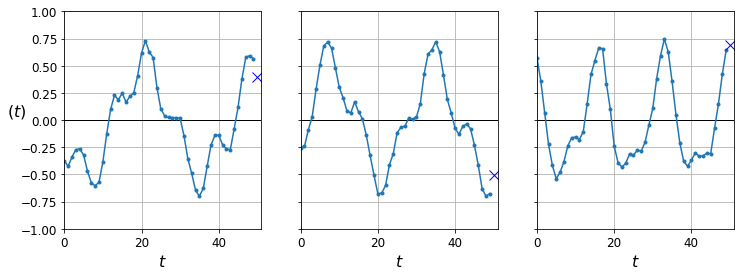

In [5]:
def plot_series(series, y=None, y_pred=None, x_label='$t$', y_label='$x(t)$'):
  plt.plot(series, '.-')

  if y is not None:
    plt.plot(n_steps, y, 'bx', markersize=10)
  if y_pred is not None:
    plt.plot(n_steps, y_pred , 'ro')
  plt.grid(True)

  if x_label:
    plt.xlabel(x_label, fontsize=16)
  if y_label:
    plt.ylabel(y_label, fontsize=16, rotation=0)

  plt.hlines(0, 0, 100, linewidth=1)
  plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
  plt.sca(axes[col])
  plot_series(X_valid[col, :, 0], y_valid[col, 0], y_label=('$(t)$' if col==0 else None))

plt.show()

## Baseline Metrics

Before we start using RNNs, it is often a good idea to have a few baseline metrics, or else we may end up thinking our model works great when in fact it is doing worse than basic models.

For example, the simplest approach is to predict the last value in each series. This is called naive forecasting , and it is sometimes surprisingly difficult to outperform. In this case, it gives us a mean squared error of about 0.020:

In [6]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_absolute_error(y_valid, y_pred))

0.11627829

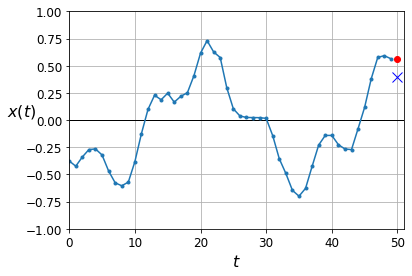

In [7]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Another simple approach is to use a fully connected network. Since it expects a flat list of features for each input, we need to add a Flatten layer. 

Let’s just use a simple Linear Regression model so that each prediction will be a linear combination of the values in the time series:

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)                           
])

model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 3s 378us/sample - loss: 0.1004 - val_loss: 0.0559
Epoch 2/20
7000/7000 [==============================] - 1s 88us/sample - loss: 0.0386 - val_loss: 0.0269
Epoch 3/20
7000/7000 [==============================] - 1s 76us/sample - loss: 0.0205 - val_loss: 0.0162
Epoch 4/20
7000/7000 [==============================] - 1s 75us/sample - loss: 0.0133 - val_loss: 0.0118
Epoch 5/20
7000/7000 [==============================] - 1s 80us/sample - loss: 0.0104 - val_loss: 0.0098
Epoch 6/20
7000/7000 [==============================] - 1s 81us/sample - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
7000/7000 [==============================] - 1s 82us/sample - loss: 0.0080 - val_loss: 0.0078
Epoch 8/20
7000/7000 [==============================] - 1s 76us/sample - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
7000/7000 [==============================] - 1s 83us/sample - loss: 0.0066 - val_loss: 0.0065
Epoch 

In [10]:
model.evaluate(X_valid, y_valid, verbose=0)

0.004145486194640398

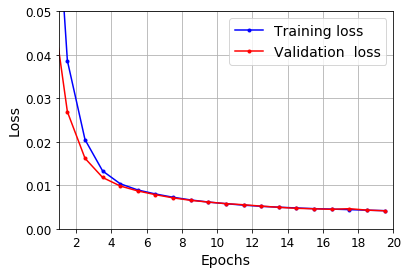

In [9]:
def plot_learning_curves(loss, val_loss):
  plt.plot(np.arange(len(loss)) + 0.5, loss, 'b.-', label='Training loss')
  plt.plot(np.arange(len(val_loss)) + 0.5, val_loss, 'r.-', label='Validation  loss')

  plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
  plt.axis([1, 20, 0, 0.05])
  plt.legend(fontsize=14)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.grid(True)

plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

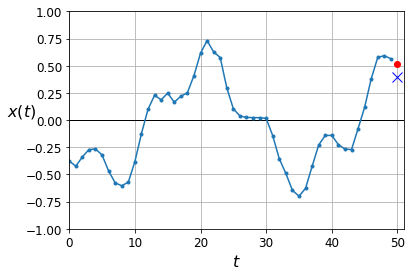

In [11]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

we get an MSE of about 0.004. That’s much better than the naive approach!

## Simple RNNs

Let’s see if we can beat that with a simple RNN:

```python
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])                     
])
```

That’s really the simplest RNN you can build. It just contains a single layer, with a single neuron.

We do not need to specify the length of the input sequences, since a recurrent neural network can process any number of time steps (this is why we set the first input dimension to None). 

By default, the SimpleRNN layer uses the hyperbolic tangent activation function. It works exactly as we saw earlier: 
* the initial state h (init) is set to 0, and it is passed to a single recurrent neuron, 
* along with the value of the first time step, x(0) . 
* The neuron computes a weighted sum of these values and applies the hyperbolic tangent activation function to the result, and this gives the first output, y0. 

In a simple RNN, this output is also the new state h0 . This new state is passed to the same recurrent neuron along with the next input value, x (1) , and the process is repeated until the last time step. Then the layer just outputs the last value, y49 . All of this is performed simultaneously for every time series.

**Note**

By default, recurrent layers in Keras only return the final output. To make them return one output per time step, you must set return_sequences=True.

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
   keras.layers.SimpleRNN(1, input_shape=[None, 1])                              
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)

# compile
model.compile(loss='mse', optimizer=optimizer)

# train
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0972 - val_loss: 0.0491
Epoch 2/20
7000/7000 [==============================] - 7s 967us/sample - loss: 0.0372 - val_loss: 0.0298
Epoch 3/20
7000/7000 [==============================] - 7s 984us/sample - loss: 0.0255 - val_loss: 0.0220
Epoch 4/20
7000/7000 [==============================] - 7s 955us/sample - loss: 0.0200 - val_loss: 0.0178
Epoch 5/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0167 - val_loss: 0.0152
Epoch 6/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0147 - val_loss: 0.0135
Epoch 7/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0133 - val_loss: 0.0124
Epoch 8/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0124 - val_loss: 0.0117
Epoch 9/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0119 - val_loss: 0.0113
Epoch 10/2

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 0s 180us/sample - loss: 0.0109


0.010885455287992955

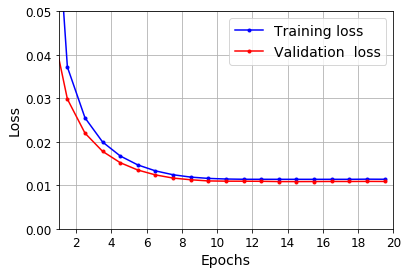

In [0]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

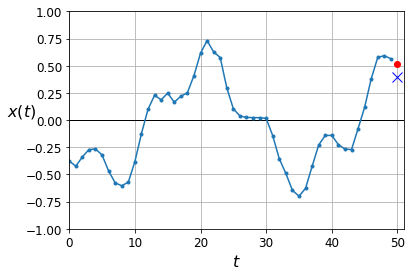

In [0]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

As we can see that its MSE reaches only 0.014, so it is better than the naive approach but it does not beat a simple linear model. 

Note that for each neuron, a linear model has one parameter per input and per time step, plus a bias term (in the simple linear model we used, that’s a total of 51 parameters). 

In contrast, for each recurrent neuron in a simple RNN, there is just one parameter per input and per hidden state dimension (in a simple RNN, that’s just the number of recurrent neurons in the layer), plus a bias term. In this simple RNN, that’s a total of just three parameters.

Apparently our simple RNN was too simple to get good performance. So let’s try to add more recurrent layers!

## Deep RNNs

It is quite common to stack multiple layers of cells and This gives you a deep RNN.

<img src='https://github.com/rahiakela/img-repo/blob/master/hands-on-machine-learning-keras-tensorflow/deeprnn.png?raw=1' width='800'/>

Implementing a deep RNN with tf.keras is quite simple: just stack recurrent layers.

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
   keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
   keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
   keras.layers.SimpleRNN(1),                             
])

**Note**

Make sure to set return_sequences=True for all recurrent layers (except the last one, if you only care about the last output). If you don’t, they will output a 2D array (containing only the output of the last time step) instead of a 3D array (containing outputs for all time steps), and the next recurrent layer will complain that you are not feeding it sequences in the expected 3D format.

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 20)          820       
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 1)                 22        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 22s 3ms/sample - loss: 0.0433 - val_loss: 0.0073
Epoch 2/20
7000/7000 [==============================] - 20s 3ms/sample - loss: 0.0066 - val_loss: 0.0052
Epoch 3/20
7000/7000 [==============================] - 21s 3ms/sample - loss: 0.0051 - val_loss: 0.0043
Epoch 4/20
7000/7000 [==============================] - 22s 3ms/sample - loss: 0.0045 - val_loss: 0.0044
Epoch 5/20
7000/7000 [==============================] - 21s 3ms/sample - loss: 0.0040 - val_loss: 0.0038
Epoch 6/20
7000/7000 [==============================] - 22s 3ms/sample - loss: 0.0038 - val_loss: 0.0042
Epoch 7/20
7000/7000 [==============================] - 21s 3ms/sample - loss: 0.0037 - val_loss: 0.0033
Epoch 8/20
7000/7000 [==============================] - 21s 3ms/sample - loss: 0.0036 - val_loss: 0.0035
Epoch 9/20
7000/7000 [==============================] - 21s 3ms/sample - loss: 0.0034 - val_loss: 0.0038
Epoch 1

In [0]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 1s 396us/sample - loss: 0.0029


0.002934106146916747

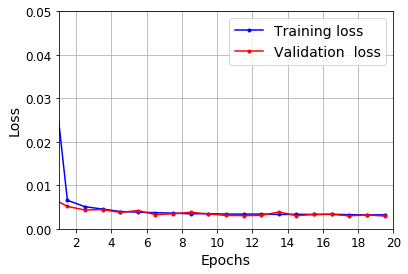

In [0]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

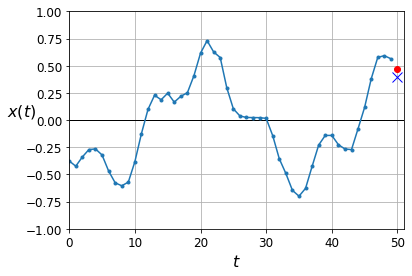

In [0]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

You will find that it reaches an MSE of 0.003. We finally managed to beat the linear model!

Note that the last layer is not ideal: it must have a single unit because we want to forecast a univariate time series, and this means we must have a single output value per time step.

However, having a single unit means that the hidden state is just a single number. That’s really not much, and it’s probably not that useful; presumably, the RNN will mostly use the hidden states of the other recurrent layers to carry over all the information it needs from time step to time step, and it will not use the final layer’s hidden state very much. 

Moreover, since a SimpleRNN layer uses the tanh activation function by default, the predicted values must lie within the range –1 to 1. But what if you want to use another activation function? 

For both these reasons, it might be preferable to replace the output layer with a Dense layer: it would run slightly faster, the accuracy would be roughly the same, and it would allow us to choose any output activation function we want. If you make this change, also make sure to remove return_sequences=True from the second (now last) recurrent layer: 


In [0]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)                             
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 16s 2ms/sample - loss: 0.0221 - val_loss: 0.0053
Epoch 2/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0043 - val_loss: 0.0037
Epoch 3/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0035 - val_loss: 0.0032
Epoch 4/20
7000/7000 [==============================] - 16s 2ms/sample - loss: 0.0033 - val_loss: 0.0032
Epoch 5/20
7000/7000 [==============================] - 16s 2ms/sample - loss: 0.0032 - val_loss: 0.0030
Epoch 6/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0031 - val_loss: 0.0030
Epoch 7/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0031 - val_loss: 0.0028
Epoch 8/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0031 - val_loss: 0.0028
Epoch 9/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0030 - val_loss: 0.0029
Epoch 1

In [0]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 1s 287us/sample - loss: 0.0026


0.0025768041349947452

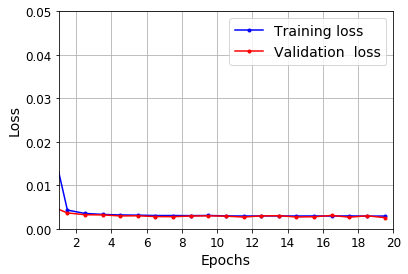

In [0]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

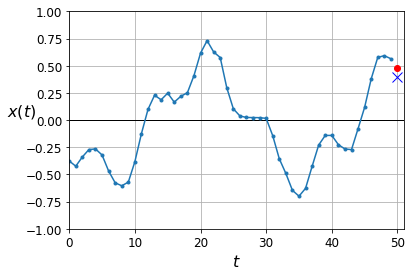

In [0]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()